## **Disclaimer!**
This notebook is meant to be used by anyone interested in replicating our model or playing around with the data. In order to access all features, please go to this [Google Drive Folder](https://drive.google.com/drive/folders/1kUTkGI89PJRl0dVy79xIZuH9Qokl9Stq) and store it on your own Google Drive. By clicking on the folder name "Thesis_LucaThoms" and selecting "Add a shortcut to Drive", all necessary files are automatically shared with your main Drive environment without having to download all the data or files individually! After that, simply run all the code as you like.

## **Setup**

Loading in required packages, setting up devices (e.g., cuda), and mounting Google Drive for data/model access

In [1]:
import os
import json
import random
import time
import cv2
import pickle

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import plotly.figure_factory as ff
import statsmodels.api as sm
from numpy.linalg import norm
from matplotlib import colors
from scipy.stats import mode
from sklearn.metrics.pairwise import cosine_similarity
from statsmodels.stats.outliers_influence import variance_inflation_factor
from keras.utils import to_categorical
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.distributions
import torchvision
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"You are using a {device.type} device.")

You are using a cpu device.


In [2]:
# Define directory to access image folders, labels, and pre-trained models
drive.mount('/content/drive', force_remount = True)
our_data_dir = '/content/drive/MyDrive/Thesis_LucaThoms/'

Mounted at /content/drive


## **Helper Functions**

Various helper functions, assisting with plotting, padding, scaling, one-hot encoding, and augmentation of tasks.

In [3]:
# Visualization Function
def plot_one(task, ax, i, train_or_test, input_or_output='!'):
    cmap = colors.ListedColormap(
    ['#000000', '#0074D9','#FF4136','#2ECC40','#FFDC00',
     '#AAAAAA', '#F012BE', '#FF851B', '#7FDBFF', '#870C25'])
    norm = colors.Normalize(vmin=0, vmax=9)
    
    if input_or_output == '!':
        input_matrix = task
    else:
        input_matrix = task[train_or_test][i][input_or_output]

    ax.imshow(input_matrix, cmap=cmap, norm=norm)
    ax.grid(True, which='both', color='lightgrey', linewidth=0.5)    
    ax.set_yticks([x-0.5 for x in range(1+len(input_matrix))])
    ax.set_xticks([x-0.5 for x in range(1+len(input_matrix[0]))])     
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_title(train_or_test + ' ' + input_or_output, size='small')

def plot_task(task, idx):   
    num_train = len(task['train'])
    fig, axs = plt.subplots(2, num_train, figsize=(2.5*num_train,2.5*2))
    for i in range(num_train):     
        plot_one(task, axs[0,i], i, 'train', 'input')
        plot_one(task, axs[1,i], i, 'train', 'output')        
    plt.tight_layout()
    plt.show()        
        
    num_test = len(task['test'])
    num_outp = len(task['test'][0])
    fig, axs = plt.subplots(2, num_test, figsize=(2.5*num_test,2.5*2))
    if num_test == 1: 
        plot_one(task, axs[0], 0, 'test', 'input')
        if num_outp > 1:
            plot_one(task, axs[1], 0, 'test', 'output')  
    else:
        for i in range(num_test):      
            plot_one(task, axs[0,i], i, 'test', 'input')
            plot_one(task, axs[1,i], i, 'test', 'output')  
    plt.tight_layout()
    plt.show() 

def plot_ARC(example_num = None, path = 'training'):
    idx = random.randint(0, 99) if example_num is None else example_num

    task_file = f'{eval(path + "_path")}{(eval(path + "_tasks_files"))[idx]}'
    with open(task_file, 'r') as f:
        example = json.load(f)

    plot_task(example, idx)

def plot_pix_acc(X_inp, X_out):
    per_diff = accuracy(X_inp, X_out)
    m = np.mean(per_diff)

    fig, ax = plt.subplots(figsize=(11,5))
    plt.plot(per_diff, color='steelblue', marker='.', linewidth=0)
    plt.axhline(m, xmax = len(per_diff), color='firebrick')
    plt.title(f'Accuracy of Task Reconstruction (Tasks: {len(per_diff)})', size='medium')
    plt.xlabel('Case')
    plt.ylabel('Correct Pixel (%)')
    plt.text(len(per_diff)/2, m+0.01, f'{(m*100).round(2)}%', size='medium', weight='bold')    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(xmax=max([1])))
    plt.margins(x=0.01)
    plt.show()
    print(f'Number of 100% Correct: {per_diff.count(1)}')
    print(f'Number of 90%+ Correct: {sum(i >= 0.9 for i in per_diff)}')
    print(f'Number of 80%+ Correct: {sum(i >= 0.8 for i in per_diff)}')
    print(f'Number of 70%+ Correct: {sum(i >= 0.7 for i in per_diff)}')

def plot_pix_heatmap(X_inp, X_out):
    pix_diff = []
    for i in range(len(X_inp)):
        pix_diff.append(X_inp[i] == X_out[i])

    pix_sum = np.sum(pix_diff, axis=0)

    fig, ax = plt.subplots(figsize=(5,5)) 
    heatmap = sns.heatmap(pix_sum, cmap='inferno_r', square=True) # oder viridis_r
    plt.title('Accuracy of Individual Pixel Reconstruction', size='medium', y=1.04)
    plt.text(0.2, 32, f'Number of 100% Correct Pixels: {np.count_nonzero((pix_sum == len(X_inp)))}', size='medium')
    plt.axis('off')
    plt.show()

In [4]:
# Pre-Processing Function 
def padding(X, height=30, width=30, direction='norm'):
    h = X.shape[0]
    w = X.shape[1]

    a = (height - h) // 2
    aa = height - a - h

    b = (width - w) // 2
    bb = width - b - w

    if direction == 'norm':
        X_pad = np.pad(X, pad_width=((a, aa), (b, bb)), mode='constant')
    else: 
        if height == 30 and width == 30:
            X_pad = X[:, :]
        elif height == 30:
            X_pad = X[:, abs(bb):b]
        elif width == 30: 
            X_pad = X[abs(aa):a, :]
        else:
            X_pad = X[abs(aa):a, abs(bb):b]

    return X_pad

def scaling(X, height=30, width=30, direction='norm'):
    h = height/X.shape[0]
    w = width/X.shape[1]
    d = np.floor(min(h, w)).astype(int)
      
    X_scaled = np.kron(X, np.ones((d, d)))

    if direction == 'norm':
        return padding(X_scaled, height, width).astype(int)
    else:
        return d, X_scaled.shape

def reverse_scaling(X_orig, X_pred):
    d, X_shape = scaling(X_orig, 30, 30, direction='rev')
    
    X_pad_rev = padding(X_pred, X_shape[0], X_shape[1], direction='rev')
    
    mm = X_shape[0] // d
    nn = X_shape[1] // d
    X_sca_rev = X_pad_rev[:mm*d, :nn*d].reshape(mm, d, nn, d)

    X_re = np.zeros((mm, nn)).astype(int)
    for i in range(mm):
        for j in range(nn):
            X_re[i,j] = mode(X_sca_rev[i,:,j,:], axis=None, keepdims=False)[0]

    return X_re

def one_hot_encoder(X):
    one_hot = (np.arange(10) == X[..., None]).astype(int)
    
    return np.transpose(one_hot, axes = [2, 0, 1])

def reverse_one_hot_encoder(X):
    one_hot_rev = np.argmax(np.transpose(X, axes=[1,2,0]), axis=-1)

    return one_hot_rev

def replace_values(X, dic):
    return np.array([dic.get(i, -1) for i in range(X.min(), X.max() + 1)])[X - X.min()]

def get_all_matrix(X_full):
    X_fill = []
    for X_task in X_full:
        for X_single in X_task:
            X_fill.append(np.array(X_single))
    
    return X_fill

def get_final_matrix(X_full, stage="."):
    if stage != "train":
        X_full = get_all_matrix(X_full)

    X_full_mat = []
    for i in range(len(X_full)):
        X_sca = scaling(X_full[i], 30, 30)
        X_one = one_hot_encoder(X_sca)
        X_full_mat.append(X_one)

    return X_full_mat

def augment_color(X_full, y_full):
    X_flip = []
    y_flip = []
    for X, y in zip(X_full, y_full): 
        X_rep = np.tile(X, (10, 1, 1))
        X_flip.append(X_rep[0])
        y_rep = np.tile(y, (10, 1, 1))
        y_flip.append(y_rep[0])
        for i in range(1, len(X_rep)):
            rep = np.arange(10)
            orig = np.arange(10)
            np.random.shuffle(rep)
            dic = dict(zip(orig, rep))
            X_flip.append(replace_values(X_rep[i], dic))
            y_flip.append(replace_values(y_rep[i], dic))

    return X_flip, y_flip

def augment_rotate(X_full, y_full):
    X_rot = []
    y_rot = []
    for X, y in zip(X_full, y_full):
        k = random.randint(0, 4)
        X_rot.append(np.rot90(X, k))
        y_rot.append(np.rot90(y, k))
    
    return X_rot, y_rot

def augment_mirror(X_full, y_full):
    X_mir = []
    y_mir = []
    for X, y in zip(X_full, y_full): 
        X_mir.append(X)
        y_mir.append(y)

        X_rep = X.copy()
        n = X_rep.shape[1]
        for i in range(n // 2):
            X_rep[:, n - i - 1] = X_rep[:, i]
        
        y_rep = y.copy()
        n = y_rep.shape[1]
        for i in range(n // 2):
            y_rep[:, n - i - 1] = y_rep[:, i]
        
        X_mir.append(X_rep)
        y_mir.append(y_rep)

    return X_mir, y_mir

def preprocess_matrix(X_full, y_full, aug=[True, True, True]):
    X_full = get_all_matrix(X_full)
    y_full = get_all_matrix(y_full)

    if aug[0]:
        print("Augmentation: Random Color Flipping")
        X_full, y_full = augment_color(X_full, y_full)
    
    if aug[1]:
        print("Augmentation: Random Rotation")
        X_full, y_full = augment_rotate(X_full, y_full)

    if aug[2]:
        print("Augmentation: Midpoint Mirroring")
        X_full, y_full = augment_mirror(X_full, y_full)

    return X_full, y_full

# Convenience Functions
def accuracy(X_inp, X_out):
    per_diff = []
    for i in range(len(X_inp)):
        raw_diff = np.count_nonzero(X_inp[i] == X_out[i])
        per_diff.append(raw_diff / X_inp[i].size)

    return per_diff

def solved_tasks(X_inp, X_out):
    per_diff = accuracy(X_inp, X_out)
    
    full_comp = [i for i, e in enumerate(per_diff) if e == 1]
    nfull_comp = [i for i, e in enumerate(per_diff) if 1 > e > 0.95]

    print(f'The approach fully solved:')
    print(*full_comp, sep = ', ')
    print(f'The approach nearly solved:')
    print(*nfull_comp, sep = ', ')

    return full_comp

def split_list(a_list):
    half = len(a_list)//2
    
    return a_list[:half], a_list[half:]

def convo_eff(w = 30, num = 1, k = 3, p = 0, s = 1):
    for i in range(num):
        w = ((w - k + (2*p))/s) + 1

    return w

def add_noise(X, noise=0.3):
    X_noise = X[0].unsqueeze(0)
    for i in range(1, len(X)):
        # Clone tensor
        X_clone = X[i].detach().clone()

        # Count the number of 1s in the array
        num_ones = torch.count_nonzero(X_clone).item()

        # Calculate the number of 1s to replace with 0s
        num_to_replace = int(noise * num_ones)

        # Get the indices of the 1s
        indices = torch.argwhere(X_clone == 1).transpose(1,0)

        # Randomly shuffle the indices of the 1s
        idx = torch.randperm(indices[0].nelement())
        indices = indices[:, idx]

        # Replace the first num_to_replace 1s with 0s
        indices_to_replace = indices[:, :num_to_replace]
        X_clone[indices_to_replace[0,:], indices_to_replace[1,:], indices_to_replace[2,:]] = 0

        X_noise = torch.cat((X_noise, X_clone.unsqueeze(0)), dim=0)

    return X_noise

## **Load Data**

Loading in the JSON files containing the raw tasks. Tasks are encoded as matrices divided into train/test and input/output sections, containing numbers 0-9 which describe the color palette (e.g., red, orange). The below code makes use of this internal structure to access the train and test data in separate objects.

In [5]:
training_path = f'{our_data_dir}Data/data_training/'
evaluation_path = f'{our_data_dir}Data/data_evaluation/'
test_path = f'{our_data_dir}Data/data_test/'

training_tasks_files = sorted(os.listdir(training_path))
evaluation_tasks_files = sorted(os.listdir(evaluation_path))
test_tasks_files = sorted(os.listdir(test_path))

In [6]:
training_tasks = []
for task_file in training_tasks_files:
    with open(f'{training_path}{task_file}', 'r') as f:
        task = json.load(f)
        training_tasks.append(task)

X_test, y_test, X_train, y_train = [[] for _ in range(4)]

for task in training_tasks:
    Xs_test, ys_test, Xs_train, ys_train = [[] for _ in range(4)]

    for pair in task["test"]:
        Xs_test.append(pair["input"])
        ys_test.append(pair["output"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test.append(Xs_test)
    y_test.append(ys_test)
    X_train.append(Xs_train)
    y_train.append(ys_train)

# To reduce test inputs to one task for later model evaluation
for i in range(len(X_test)):
    if len(X_test[i]) > 1:
        X_test[i] = [X_test[i][0]]
        y_test[i] = [y_test[i][0]]

# Example
X_test[3]

[[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 4, 4, 4, 4, 4, 4, 0, 0, 0],
  [0, 4, 0, 0, 0, 0, 0, 4, 0, 0],
  [0, 0, 4, 0, 0, 0, 0, 0, 4, 0],
  [0, 0, 0, 4, 0, 0, 0, 0, 0, 4],
  [0, 0, 0, 0, 4, 4, 4, 4, 4, 4],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]]

### **Load Evaluation Data**

In [166]:
evaluation_tasks = []
for task_file in evaluation_tasks_files:
    with open(f'{evaluation_path}{task_file}', 'r') as f:
        task = json.load(f)
        evaluation_tasks.append(task)

X_test_e, y_test_e, X_train_e, y_train_e = [[] for _ in range(4)]

for task in evaluation_tasks:
    Xs_test, ys_test, Xs_train, ys_train = [[] for _ in range(4)]

    for pair in task["test"]:
        Xs_test.append(pair["input"])
        ys_test.append(pair["output"])

    for pair in task["train"]:
        Xs_train.append(pair["input"])
        ys_train.append(pair["output"])
    
    X_test_e.append(Xs_test)
    y_test_e.append(ys_test)
    X_train_e.append(Xs_train)
    y_train_e.append(ys_train)

# To reduce test inputs to one task for later model evaluation
for i in range(len(X_test_e)):
    if len(X_test_e[i]) > 1:
        X_test_e[i] = [X_test_e[i][0]]
        y_test_e[i] = [y_test_e[i][0]]

## **Exploration**

Exploring the features of the tasks visually: Means, Distributions, Skews.

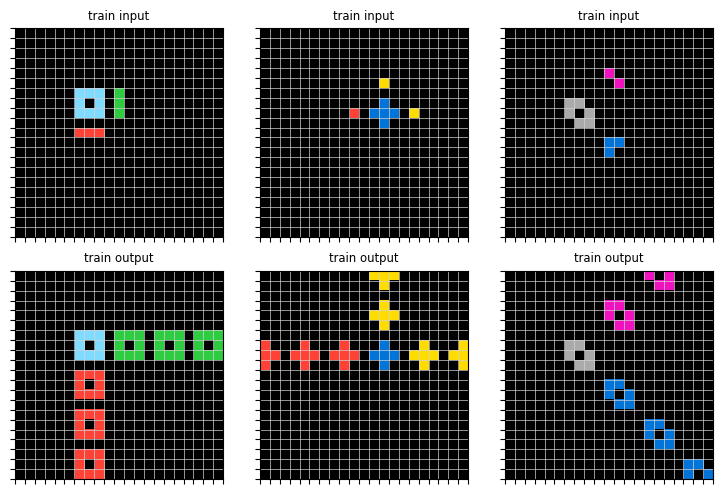

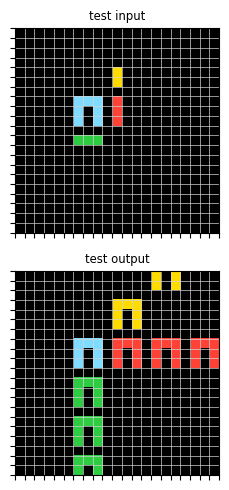

In [ ]:
matrices = get_all_matrix(X_test)

plot_ARC(4, path = "training")

In [ ]:
means = [np.mean(matrix) for matrix in matrices]
fig = ff.create_distplot([means], group_labels=["Means"], colors=["green"])
fig.update_layout(title_text="Distribution of matrix mean values")

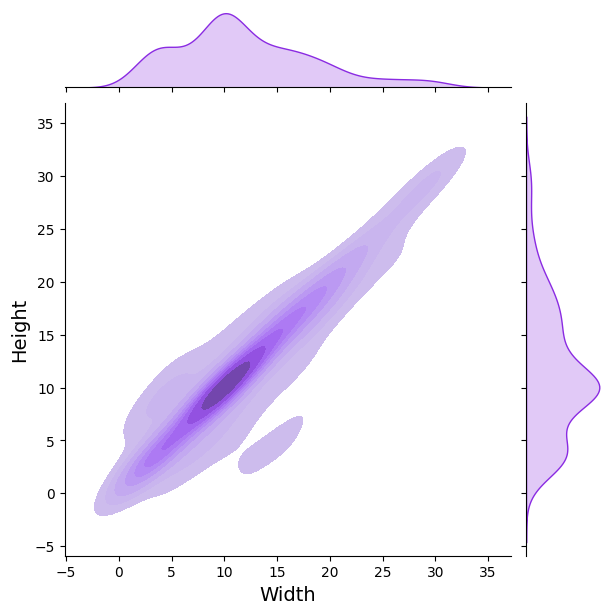

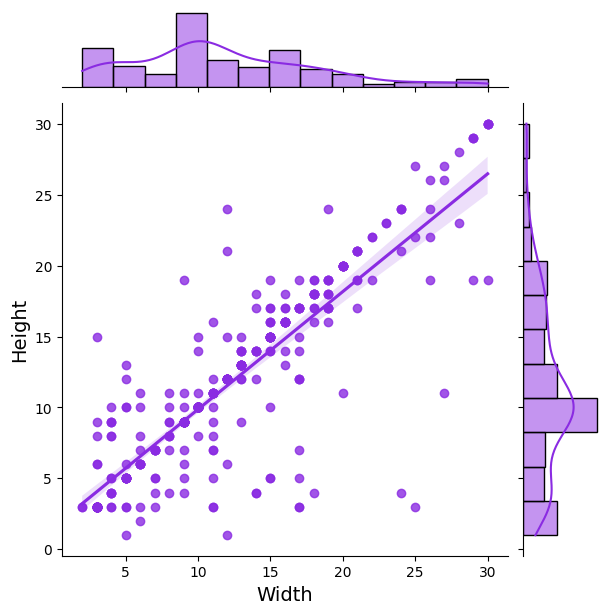

In [ ]:
heights = [np.shape(matrix)[0] for matrix in matrices]
widths = [np.shape(matrix)[1] for matrix in matrices]

plot = sns.jointplot(x=widths, y=heights, kind="kde", fill=True, thresh = 0.09, color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

plot = sns.jointplot(x=widths, y=heights, kind="reg", color="blueviolet")
plot.set_axis_labels(xlabel="Width", ylabel="Height", fontsize=14)
plt.show(plot)

## **PyTorch Dataset**

Preparing the data for the PyTorch framework, applying pre-processing (e.g., scaling, one-hot encoding, padding) and augmentations (e.g., color_flip, rotation). Can be directly processed into train_loader PyTorch method.


In [187]:
# Load in Dataset (incl. Augmentations, Padding)
class ARCDataset(Dataset):
    def __init__(self, X, y, stage="train", aug=[True, True, True]):
        self.stage = stage

        if self.stage == "train":
            self.X, self.y = preprocess_matrix(X, y, aug)
            self.X = get_final_matrix(self.X, self.stage)
            self.y = get_final_matrix(self.y, self.stage)
        else:
            self.X = get_final_matrix(X, self.stage)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        inp = self.X[idx]
        inp = torch.tensor(inp, dtype=torch.float32)

        if self.stage == "train":
            outp = self.y[idx]
            outp = torch.tensor(outp, dtype=torch.float32)
            return inp, outp
        else:
            return inp

In [15]:
# Defining loaders function to ease data preparation
def data_load(X_train, y_train, stage="train", aug=[False, False, False], batch_size=1, shuffle=False):

    data_set = ARCDataset(X_train, y_train, stage=stage, aug=aug)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    del data_set

    return data_loader

Augmentation: Random Color Flipping
Augmentation: Random Rotation
Augmentation: Midpoint Mirroring


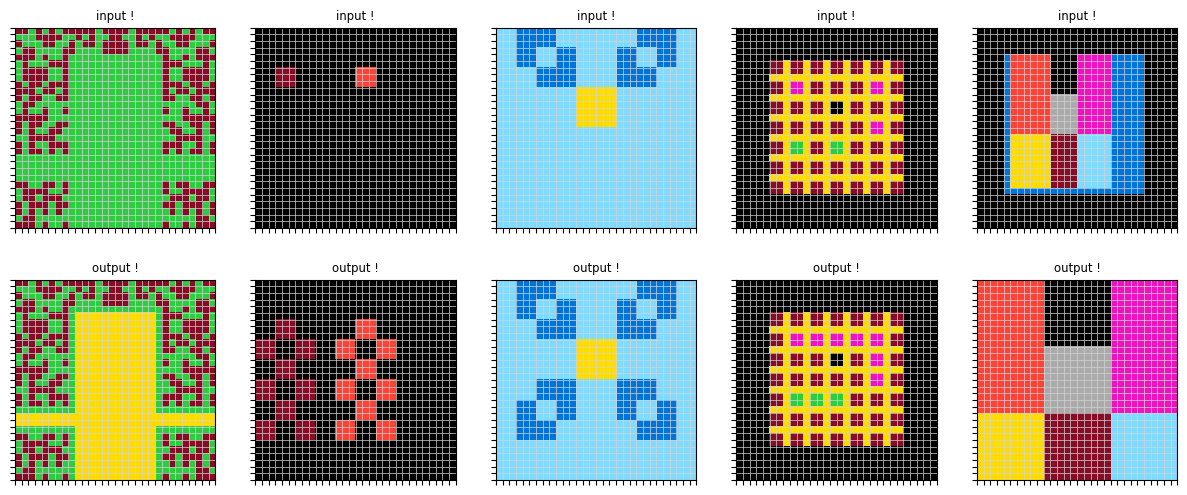

In [186]:
# Showcase Padding, One-Hot Encoding, Dimensionality, and Augmentation with regards to Colors
train_loader = data_load(X_train, y_train, aug=[True, True, True], shuffle=True)

fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    idx = random.randrange(len(train_loader.dataset.X))
    plot_one(reverse_one_hot_encoder(train_loader.dataset.X[idx]), axs[0,i], i, 'input')
    plot_one(reverse_one_hot_encoder(train_loader.dataset.y[idx]), axs[1,i], i, 'output')

## **Variational Autoencoder**
Outlines the VAE architecture (modifiable), including encoder, decoder, and probabilistic sampling of latent representation.

In [21]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, img_channels=10, feature_dim=[128, 2, 2], latent_dim=128):
        super(VariationalAutoencoder, self).__init__()

        self.f_dim = feature_dim
        kernel_vae = 4
        stride_vae = 2

        # Initializing the convolutional layers and 2 full-connected layers for the encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(in_channels=img_channels, 
                      out_channels=128, 
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=kernel_vae,
                      stride=stride_vae),
            nn.LeakyReLU())
        self.fc_mu = nn.Linear(np.prod(self.f_dim), latent_dim)
        self.fc_var = nn.Linear(np.prod(self.f_dim), latent_dim)

        # Initializing the fully-connected layer and convolutional layers for decoder
        self.dec_inp = nn.Linear(latent_dim, np.prod(self.f_dim))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128,
                               out_channels=128,
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.LeakyReLU(),
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=128, 
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.LeakyReLU(),
            # Final Layer
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=img_channels, 
                               kernel_size=kernel_vae,
                               stride=stride_vae),
            nn.Sigmoid())

    def encode(self, x):
        # Input is fed into convolutional layers sequentially
        # The output feature map are fed into 2 fully-connected layers to predict mean (mu) and variance (logVar)
        # Mu and logVar are used for generating middle representation z and KL divergence loss
        x = self.encoder(x)
        x = x.view(-1, np.prod(self.f_dim))
        mu = self.fc_mu(x)
        logVar = self.fc_var(x)
        return mu, logVar

    def reparameterize(self, mu, logVar):
        # Reparameterization takes in the input mu and logVar and sample the mu + std * eps
        std = torch.exp(logVar/2)
        eps = torch.randn_like(std)
        return mu + std * eps

    def decode(self, z):
        # z is fed back into a fully-connected layers and then into transpose convolutional layers
        # The generated output is the same size of the original input
        x = self.dec_inp(z)
        x = x.view(-1, self.f_dim[0], self.f_dim[1], self.f_dim[2])
        x = self.decoder(x)
        return x.squeeze()

    def forward(self, x):
        # The entire pipeline of the VAE: encoder -> reparameterization -> decoder
        # output, mu, and logVar are returned for loss computation
        mu, logVar = self.encode(x)
        z = self.reparameterize(mu, logVar)
        out = self.decode(z)
        return out, mu, logVar

# Print Architecture
VariationalAutoencoder()

VariationalAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(10, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (5): LeakyReLU(negative_slope=0.01)
  )
  (fc_mu): Linear(in_features=512, out_features=128, bias=True)
  (fc_var): Linear(in_features=512, out_features=128, bias=True)
  (dec_inp): Linear(in_features=128, out_features=512, bias=True)
  (decoder): Sequential(
    (0): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(128, 128, kernel_size=(4, 4), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 10, kernel_size=(4, 4), stride=(2, 2))
    (5): Sigmoid()
  )
)

In [22]:
# Check convolutional effect on image/task size (for feature_dim adjustment)
convo_eff(w = 30, num = 3, k = 4, p = 0, s = 2)

2.0

## **Training**
Training the layers/weights of the β-VAE to generate representations producing accurate reconstructions of the given inputs. For each epoch the respective loss is printed, calculated through a combination of binary cross entropy and Kullback-Leibler divergence.

In [19]:
# Define model
vae = VariationalAutoencoder().to(device)
train_loader = data_load(X_train, y_train, aug=[True, True, True], batch_size=64, shuffle=True)

# Training the network for a given number of epochs
def train(model, train_loader, epochs=50):
    optimizer = AdamW(model.parameters(), lr=0.001, weight_decay=0.2)
    for epoch in range(epochs):
        model.train()
        for batch_idx, (input, output) in enumerate(train_loader):

            # Combine input & output, adding noise, attaching to device
            in_out = torch.cat((input, output), dim=0)
            in_out = in_out.to(device)
            # in_out_noisy = add_noise(in_out, noise=0.2)
            # in_out_noisy = in_out_noisy.to(device)

            # Feeding a batch of images into the network to obtain the output image, mu, and logVar 
            out, mu, logVar = model(in_out)

            # The loss is the BCE loss combined with the KL divergence to ensure the distribution is learnt
            kl_divergence = -0.5 * torch.sum(1 + logVar - mu.pow(2) - logVar.exp())
            loss = F.binary_cross_entropy(out, in_out, reduction='sum') + kl_divergence

            # Backpropagation based on the loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print('Epoch {}: Loss {}'.format(epoch+1, loss))
    
    return model

vae_final = train(vae, train_loader, epochs=30)

torch.save(vae_final, '/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128.pt')

## **Evaluation**
Evaluating the above training through means of auxillary tools:
1. Random display of input and respective reconstructions
2. Plot demonstrating task reconstruction accuracy (measured by correct pixels)
3. Heatmap illustrating individual pixel accuracy

In [188]:
# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128_bce_4k_2s_wd02.pt', map_location=torch.device(device))
# eval_loader = data_load(X_train_e, y_train_e, aug=[True, True, True], batch_size=64, shuffle=True)
eval_loader = data_load(X_train, y_train)

# Create lists to store input and output (reconstructions)
X_inp = []
X_out = []

def validate(model, eval_loader):
    # Put model in evaluation mode and start reconstructions based on latent vector
    model.eval()
    with torch.no_grad():
        for batch_idx, (input, output) in enumerate(eval_loader):
            in_out = torch.cat((input, output), dim=0).to(device)
            out, mu, logVar = model(in_out)
            for i in range(len(in_out)):
                X_inp.append(reverse_one_hot_encoder(in_out[i].cpu().numpy()))
                X_out.append(reverse_one_hot_encoder(out[i].cpu().numpy()))
    return X_inp, X_out

X_inp, X_out = validate(model_vae, eval_loader)

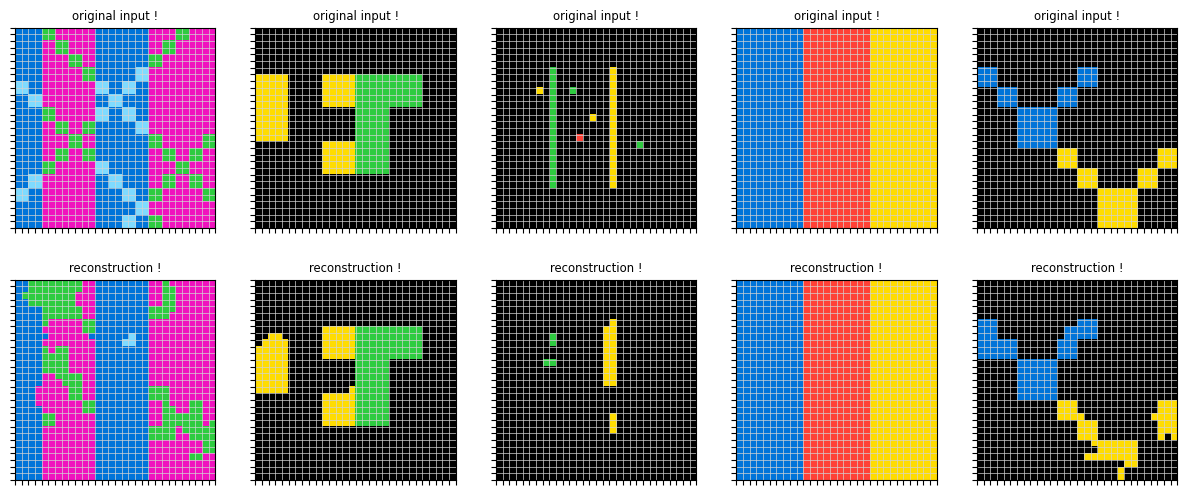

In [25]:
# Visualize five random tasks and their respective reconstructions (output)
fig, axs = plt.subplots(2, 5, figsize=(15, 6))
for i in range(5):
    idx = random.randrange(len(X_inp))
    plot_one(X_inp[idx], axs[0,i], i, 'original input')
    plot_one(X_out[idx], axs[1,i], i, 'reconstruction')

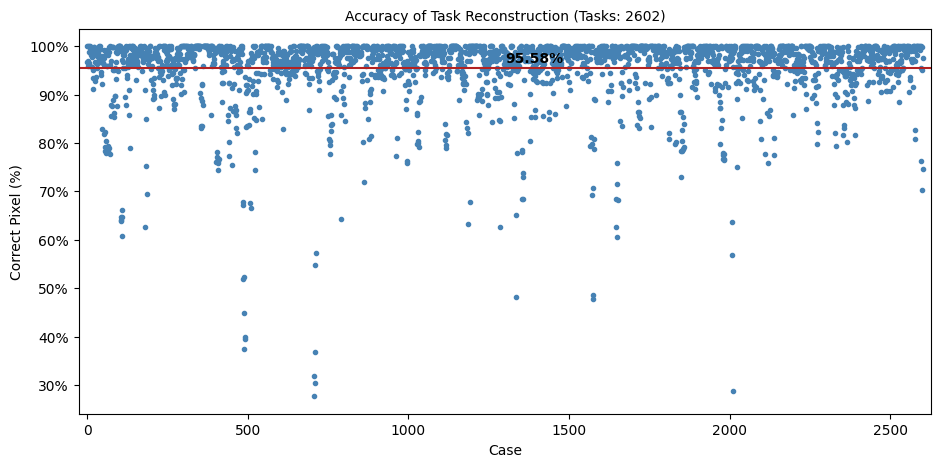

Number of 100% Correct: 458
Number of 90%+ Correct: 2304
Number of 80%+ Correct: 2495
Number of 70%+ Correct: 2560


In [ ]:
# Plot differences between input and output matrices (reconstructions)
plot_pix_acc(X_inp, X_out)

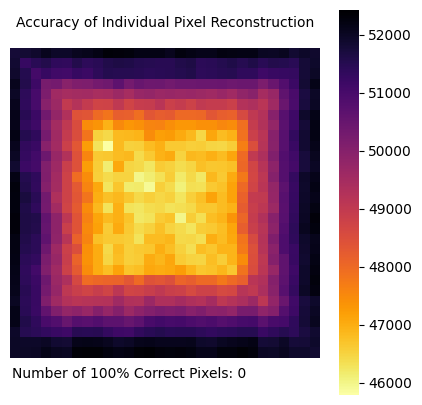

In [ ]:
# Plot heatmap of correct pixel determination by the model (absolute)
plot_pix_heatmap(X_inp, X_out)

## **Visual Analogy Completion (Predictive Model)**

First, let's define the type of data (train vs. evaluation) we want to look at.

In [189]:
# Define batch size, create dataloaders and initialize network
train_or_eval = 'train'

# Define what data we are looking at
if train_or_eval == 'train':
    y_obs = get_all_matrix(y_test)
    inp_index = np.insert(np.cumsum([len(i) for i in X_train]), 0, 0)

    test_loader_few = data_load(X_train, y_train)
    test_loader_sol = data_load(X_test, y_test)

    sol_full = [20, 37, 47, 52, 55, 102, 110, 114, 129, 177, 185, 222, 275, 290, 321, 333, 352, 354, 372, 398] # training data
else: 
    y_obs = get_all_matrix(y_test_e)
    inp_index = np.insert(np.cumsum([len(i) for i in X_train_e]), 0, 0)

    test_loader_few = data_load(X_train_e, y_train_e)
    test_loader_sol = data_load(X_test_e, y_test_e)

    sol_full = [42, 88, 92, 148, 154, 171, 217, 271, 304, 307, 325, 328, 351, 363] # evaluation/test data

# Load model for testing
model_vae = torch.load('/content/drive/MyDrive/Thesis_LucaThoms/Models/model_128_bce_4k_2s_wd02.pt', map_location=torch.device(device))

Next, run the model:

In [190]:
# Access VAE model latent vector
def visual_analogy(model, test_loader_few, test_loader_sol, inp_index, comp='average'):
    model.eval()
    with torch.no_grad():
        Z_few = []
        Z_few_i = []
        for batch_idx, (input, output) in enumerate(test_loader_few):
            
            # z_inp, _ = model.encode(input.to(device))
            mu, logVar = model.encode(input.to(device))
            z_inp = model.reparameterize(mu, logVar)

            # z_out, _ = model.encode(output.to(device))
            mu, logVar = model.encode(output.to(device))
            z_out = model.reparameterize(mu, logVar)
            
            z_diff = z_out.cpu().numpy().squeeze() - z_inp.cpu().numpy().squeeze()
            Z_few.append(z_diff)
            Z_few_i.append(z_inp.cpu().numpy().squeeze())
        
        Z_sol = []
        Z_sol_o = []
        for batch_idx, (input, output) in enumerate(test_loader_sol):

            # z_inp, _ = model.encode(input.to(device))
            mu, logVar = model.encode(input.to(device))
            z_inp = model.reparameterize(mu, logVar)
            
            Z_sol.append(z_inp.cpu().numpy().squeeze())
            Z_sol_o.append(reverse_one_hot_encoder(output.numpy().squeeze()))

        # Average rule vector
        Z_avg = []
        for i in range(len(inp_index)-1):
            Z_avg.append(np.mean(Z_few[inp_index[i]:inp_index[i+1]], axis=0))

        # Similarity rule vector (euclidean distance)
        Z_sim = []
        for i in range(len(inp_index)-1):
            Z_temp = Z_few_i[inp_index[i]:inp_index[i+1]]
            Z_euc = []
            for t in range(len(Z_temp)):
                euclidean_sim = np.linalg.norm(Z_temp[t] - Z_sol[i])
                Z_euc.append(euclidean_sim)
            idx = list(range(inp_index[i], inp_index[i+1]))[Z_euc.index(min(Z_euc))]
            Z_sim.append(Z_few[idx])

        # Check encoding consistency of all example rule vectors
        Z_cons = []
        for i in range(len(inp_index)-1):
            Z_temp = Z_few[inp_index[i]:inp_index[i+1]]
            cosine_sim = cosine_similarity(Z_temp)
            Z_cons.append(cosine_sim)
        
        # Check encoding consistency of two rule vector approaches
        Z_rule = []
        for i in range(len(Z_avg)):
            cosine_sim = np.dot(Z_avg[i], Z_sim[i])/(norm(Z_avg[i])*norm(Z_sim[i]))
            Z_rule.append(cosine_sim)

        if comp == 'average':
            Z_comp = Z_avg
        elif comp == 'similarity':
            Z_comp = Z_sim
  
        Z_sol_p = []
        for i in range(len(Z_comp)):
            z_out = Z_comp[i] + Z_sol[i]
            out = model.decode(torch.tensor(z_out, dtype=torch.float32).unsqueeze(0).to(device))
            Z_sol_p.append(reverse_one_hot_encoder(out.cpu().numpy()))
    
    return Z_sol_o, Z_sol_p, Z_cons, Z_rule

sol = []
sol_full = []
while all(i in sol_full for i in sol):

  Z_sol_o, Z_sol_p, Z_cons, Z_rule = visual_analogy(model_vae, test_loader_few, test_loader_sol, inp_index, comp='average')

  y_pred = []
  for i in range(len(y_obs)):
      y_pred.append(reverse_scaling(y_obs[i], Z_sol_p[i]))

  sol = solved_tasks(y_obs, y_pred)

The approach fully solved:
129, 398
The approach nearly solved:
64, 221, 269, 288, 341, 352, 369
The approach fully solved:
102, 398
The approach nearly solved:
64, 269, 341, 352, 369


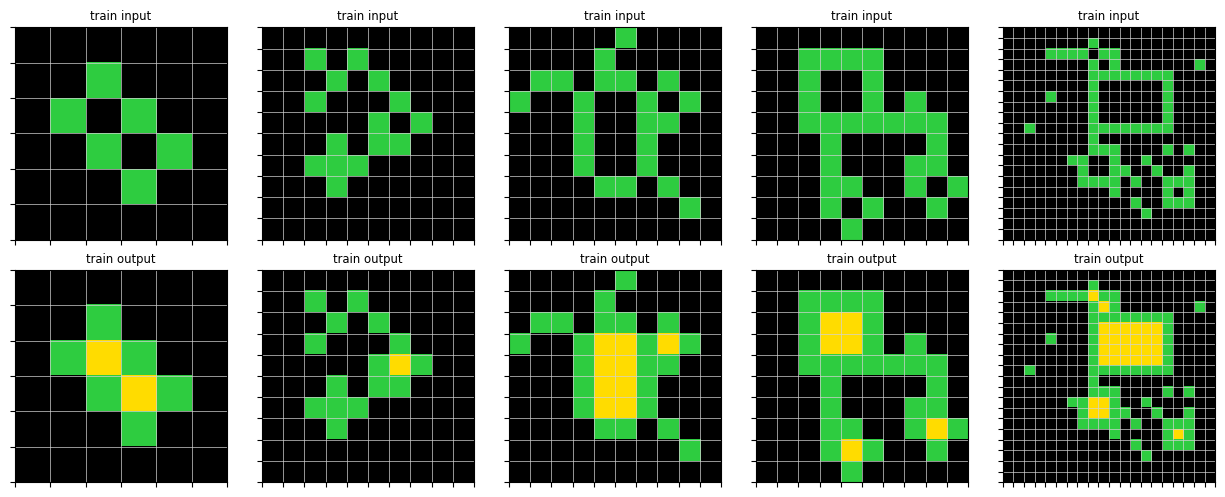

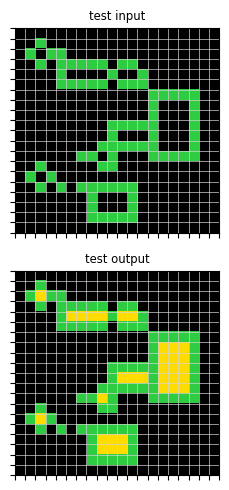

Encoding Rule Consistency 0.63:


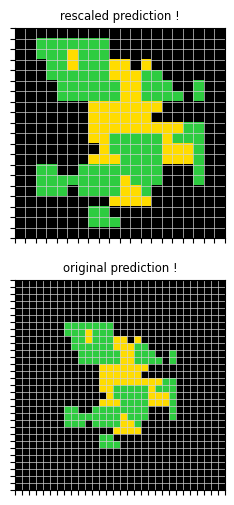

In [183]:
idx = 1
# Tasks it solved 100% correctly (training): 20, 37, 47, 52, 55, 102, 110, 114, 129, 177, 185, 222, 275, 290, 321, 333, 352, 354, 372, 398 (61, 192?)
# Tasks it solved 100% correctly (evaluation): 42, 88, 92, 148, 154, 171, 217, 271, 304, 307, 325, 328, 351, 363

# Plot ARC item
plot_ARC(idx, path = 'training')

# Plot Original and Predicted Output (resized)
fig, axs = plt.subplots(2, 1, figsize=(6, 6))
plot_one(y_pred[idx], axs[0], 0, 'rescaled prediction')
plot_one(Z_sol_p[idx], axs[1], 0, 'original prediction')

# Print Ruel Complexity
print('Encoding Rule Consistency {0:.{1}f}:'.format(Z_rule[idx], 2))
# print(Z_cons[idx])

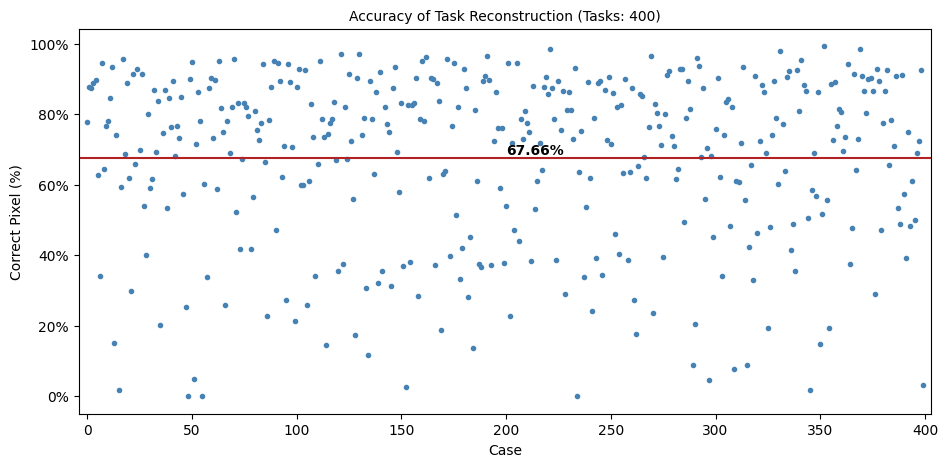

Number of 100% Correct: 0
Number of 90%+ Correct: 65
Number of 80%+ Correct: 158
Number of 70%+ Correct: 232


In [191]:
# Plot differences between original output and predicted output
plot_pix_acc(Z_sol_o, Z_sol_p)

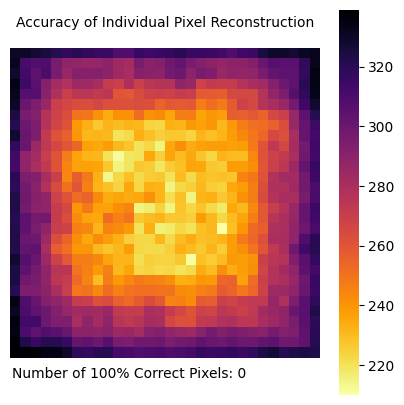

In [42]:
# Plot heatmap of correct pixel prediction by method (absolute)
plot_pix_heatmap(Z_sol_o, Z_sol_p)

## **Multiple Linear Regression**

In [192]:
# Combine both lists to retrieve indexes for Reconstruction Accuracy
X_full = [X + y for X, y in zip(X_train, y_train)]
inp_index = np.insert(np.cumsum([len(i) for i in X_full]), 0, 0)

rec_diff = accuracy(X_inp, X_out)
rec_avg = []
for i in range(len(inp_index)-1):
    rec_avg.append(np.mean(rec_diff[inp_index[i]:inp_index[i+1]], axis=0))

# Per Item Input & Output: No. of Examples, Avg Colors, Avg Void, Avg Size, Avg RoC, Avg Scaling, Size Differences (binary)
item_len = [len(i) for i in X_train]
col_avg, void_avg, size_avg, cha_avg, sca_avg, size_diff = [[] for _ in range(6)]
for _train in [X_train, y_train]:
    for item in _train:
        col_per, void_per, size_per, ver_per, hor_per, sca_per = [[] for _ in range(6)]
        for i in item:
            col_per.append(len(np.unique(np.array(i))))
            void_per.append(np.count_nonzero(np.array(i) == 0) / np.array(i).size)
            size_per.append(np.array(i).size)
            ver_per.append(np.count_nonzero(np.diff(np.array(i), axis=0)))
            hor_per.append(np.count_nonzero(np.diff(np.array(i), axis=-1)))
            
            d, _ = scaling(np.array(i), 30, 30, direction='rev')
            sca_per.append(d)

        col_avg.append(np.mean(col_per))
        void_avg.append(np.mean(void_per))
        size_avg.append(np.mean(size_per))
        cha_avg.append(np.mean([sum(x) for x in zip(ver_per, hor_per)]))
        sca_avg.append(np.mean(sca_per))
        size_diff.append(1 if len(set(size_per)) > 1 else 0)

col_change, size_change, sim_avg = [[] for _ in range(3)]
for item_x, item_y in zip(X_train, y_train):
    x_sca , y_sca, xy_col, xy_size = [[] for _ in range(4)]
    for x, y in zip(item_x, item_y):
        xy_col.append(set(np.unique(np.array(x))) == set(np.unique(np.array(y))))
        xy_size.append(np.array(x).shape == np.array(y).shape)

        x_sca.append(scaling(np.array(x), 30, 30))
        y_sca.append(scaling(np.array(y), 30, 30))

    col_change.append(0 if all(xy_col) else 1)
    size_change.append(0 if all(xy_size) else 1)
    sim_avg.append(np.mean(accuracy(x_sca, y_sca)))

col_change_t, size_change_t = [[] for _ in range(2)]
for item_x, item_t in zip(X_train, X_test):
    flat_list = [i for first_list in item_x for sec_list in first_list for i in sec_list]
    col_full, col_test = set(flat_list), set(np.unique(np.array(item_t[0])))

    xy_size = []
    for x in item_x:
        xy_size.append(np.array(x).shape == np.array(item_t[0]).shape)

    col_change_t.append(0 if all(i in col_full for i in col_test) else 1)
    size_change_t.append(0 if any(xy_size) else 1)

feature_split = {}
for feature in ["col_avg", "void_avg", "size_avg", "cha_avg", "sca_avg", "size_diff"]:
    feature_split[f'{feature}_x'], feature_split[f'{feature}_y'] = split_list(eval(feature))

# Dependent Variable: Accuracy
acc = accuracy(Z_sol_o, Z_sol_p) # on 30x30 Grid
# # acc = accuracy(y_obs, y_pred)  # on original Grid

(data := pd.DataFrame({'Number_Examples': item_len, 
                       'Average_Colors_X': feature_split['col_avg_x'],
                       'Average_Colors_y': feature_split['col_avg_y'],
                       'Average_Zeros_X': feature_split['void_avg_x'],
                       'Average_Zeros_Y': feature_split['void_avg_y'], 
                       'Average_Size_X': feature_split['size_avg_x'],
                       'Average_Size_Y': feature_split['size_avg_y'],
                       'Average_RoC_X': feature_split['cha_avg_x'],
                       'Average_RoC_Y': feature_split['cha_avg_y'],
                       'Average_Scale_X': feature_split['sca_avg_x'],
                       'Average_Scale_Y': feature_split['sca_avg_y'],
                       'Average_Reconstruction': rec_avg,
                       'Average_Similarity': sim_avg,
                       'Size_Differences': feature_split['size_diff_x'],
                       'Color_Change': col_change,
                       'Color_Change_T': col_change_t,
                       'Grid_Size_Change': size_change,
                       'Grid_Size_Change_T': size_change_t,
                       'Accuracy': acc}))

,Number_Examples,Average_Colors_X,Average_Colors_y,Average_Zeros_X,Average_Zeros_Y,Average_Size_X,Average_Size_Y,Average_RoC_X,Average_RoC_Y,Average_Scale_X,Average_Scale_Y,Average_Reconstruction,Average_Similarity,Size_Differences,Color_Change,Color_Change_T,Grid_Size_Change,Grid_Size_Change_T,Accuracy
0,5,2.000000,2.000000,0.488889,0.711111,9.000000,81.000000,5.800000,38.600000,10.000000,3.0,0.980333,0.702889,0,0,0,1,0,0.777778
1,5,2.000000,3.000000,0.801167,0.742556,147.200000,147.200000,71.600000,71.600000,3.000000,3.0,0.967444,0.950000,1,1,0,0,0,0.877778
2,3,2.000000,2.000000,0.518519,0.530864,18.000000,27.000000,18.333333,28.333333,5.000000,3.0,0.986296,0.725926,0,1,0,1,0,0.874444
3,2,2.500000,2.500000,0.809524,0.809524,99.000000,99.000000,49.000000,42.500000,2.500000,2.5,0.951389,0.904444,1,0,1,0,1,0.888889
4,3,4.000000,4.000000,0.975057,0.905518,441.000000,441.000000,29.333333,90.000000,1.000000,1.0,0.973704,0.965926,0,0,0,0,0,0.897778
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,3,3.000000,2.000000,0.739333,0.434240,205.666667,46.666667,118.000000,26.666667,1.333333,4.0,0.957778,0.469630,1,1,1,1,1,0.498889
396,3,6.333333,7.333333,0.906667,0.786667,100.000000,100.000000,26.333333,41.666667,3.000000,3.0,0.977407,0.880000,0,1,0,0,0,0.690000
397,5,3.000000,3.000000,0.600000,0.840444,5.000000,120.000000,3.000000,71.600000,6.000000,3.8,0.945889,0.780444,0,0,0,1,0,0.723333
398,8,2.000000,2.000000,0.693401,0.694444,36.375000,9.000000,17.750000,6.500000,5.375000,10.0,0.993264,0.493333,1,1,0,1,0,0.926667


In [194]:
X = data.iloc[:, 0:-1]
y = data['Accuracy']

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
lasso = sm.OLS(y, X).fit_regularized(alpha=0.1, L1_wt=0.5)

print(est.summary())
print('==============================================================================\n               Lasso\n', lasso.params)
print('==============================================================================\n          Multicollinearity\n', vif_data.to_string(index=False))

                            OLS Regression Results                            
Dep. Variable:               Accuracy   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.732
Method:                 Least Squares   F-statistic:                     61.70
Date:                Sun, 30 Apr 2023   Prob (F-statistic):          6.10e-101
Time:                        12:03:52   Log-Likelihood:                 274.90
No. Observations:                 400   AIC:                            -511.8
Df Residuals:                     381   BIC:                            -436.0
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                     -0

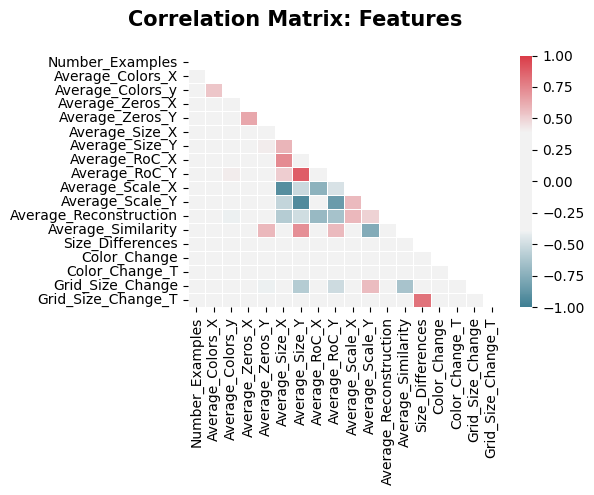

In [137]:
X = data.iloc[:, 0:-1]
corr = X.corr(method='spearman')

# Generate mask for upper triangle (just symmetric)
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Create custom colormap to highlight pos. & neg. correlations
cmap = sns.diverging_palette(220, 10, as_cmap=True, sep=100)

# Draw heatmap (/w mask & colormap)
fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(corr, mask=mask, cmap=cmap, vmin=-1, vmax=1, center=0, linewidths=.5)
fig.suptitle('Correlation Matrix: Features', fontsize=15, weight='bold')
fig.tight_layout()

## **Archiv**

In [ ]:
X_full = [X + y for X, y in zip(X_train, y_train)]

# Examples, Colors, Average Void per item input
item_len, col_len, size_len, void_avg, size_avg, sca_avg = [[] for _ in range(6)]
for item in X_full:
    flat_list = [i for first_list in item for sec_list in first_list for i in sec_list]
    col_len.append(len(set(flat_list)))
    item_len.append(len(item)//2)

    void_per, size_per, sca_per = [[] for _ in range(3)]
    for i in item:
        void_per.append(np.count_nonzero(np.array(i) == 0) / np.array(i).size)
        size_per.append(np.array(i).size)
        d, _ = scaling(np.array(i), 30, 30, direction='rev')
        sca_per.append(d)
    void_avg.append(np.mean(void_per))
    size_avg.append(np.mean(size_per))
    sca_avg.append(np.mean(sca_per))
    size_len.append(len(set(size_per)))